# Combining errors
In this notebook we explore how `specutils` does uncertainty propagation, and how to combine two spectra with different---but overlapping---extents.  That is, if a spectrum has close to, but not exactly the same wavelengths, how does specutils combine them?  These two issues are important for combining spectra of the same objects taken from different exposures and different nights, when the target's rest-frame wavelength solution can change greater than one pixel.

In [1]:
from specutils import Spectrum1D
import numpy as np
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## Spectrum 1: $S/N=20$

First we'll make a spectrum with signal-to-noise ratio equal to 20, and mean of 1.0.

In [2]:
N_points = 300
fake_wavelength = np.linspace(500, 600, num=N_points)*u.nm
mean_val, sigma = 1.0, 0.05
snr = mean_val / sigma
known_uncertainties = np.repeat(sigma, N_points) * u.Watt / u.cm**2
fake_flux = np.random.normal(loc=mean_val, scale=known_uncertainties) * u.Watt / u.cm**2

In [3]:
spec1 = Spectrum1D(spectral_axis=fake_wavelength, 
                 flux=fake_flux, 
                 uncertainty=StdDevUncertainty(known_uncertainties))

In [4]:
known_uncertainties.value[0:7]

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

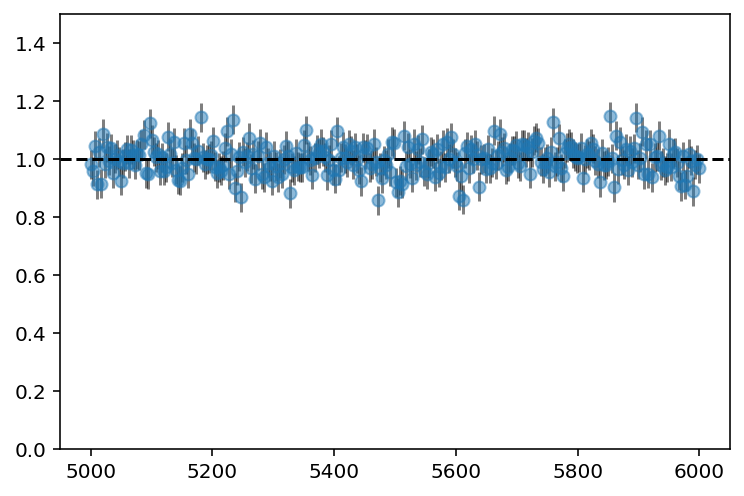

In [5]:
plt.axhline(1.0, linestyle='dashed', color='k', zorder=10)
plt.errorbar(spec1.wavelength.value, spec1.flux.value, yerr=spec1.uncertainty.array, 
             linestyle='none', marker='o', ecolor='k', alpha=0.5)
plt.ylim(0, 1.5);

# Spectrum 2: $S/N = 50$ and *conspicuously* offset in wavelength

Now we'll make a spectrum with signal-to-noise ratio equal to 50, and mean of 0.5.  The wavelength axes are *offset* by 10 nanometers.

In [6]:
N_points2 = N_points
fake_wavelength2 = np.linspace(510, 610, num=N_points2)*u.nm
mean_val2, sigma2 = 0.5, 0.01
snr = mean_val2 / sigma2
known_uncertainties2 = np.repeat(sigma2, N_points2) * u.Watt / u.cm**2
fake_flux2 = np.random.normal(loc=mean_val2, scale=known_uncertainties2) * u.Watt / u.cm**2

In [7]:
spec2 = Spectrum1D(spectral_axis=fake_wavelength2, 
                 flux=fake_flux2, 
                 uncertainty=StdDevUncertainty(known_uncertainties2))

## Add Spectrum 1 and Spectrum 2: What happens?

We expect the uncertainties to add *in quadrature*:  
$$ \sigma_{net} = \sqrt{\sigma_1^2 + \sigma2^2}$$
$$ \sigma_{net} = \sqrt{0.05^2 + 0.01^2} $$
$$=$$


In [8]:
np.hypot(0.05, 0.01)

0.050990195135927854

In [9]:
spec_net = spec1 + spec2

In [10]:
spec_net.uncertainty[0:7]

StdDevUncertainty([0.0509902, 0.0509902, 0.0509902, 0.0509902, 0.0509902,
                   0.0509902, 0.0509902])

Woohoo! Specutils *automatically* propagates the error correctly!  You can turn this error propagation *off* (I'm not sure why you would want to) by calling the method with a kwarg:

In [11]:
spec_net_no_error_propagation = spec1.add(spec2, propagate_uncertainties=False)

In [12]:
spec_net_no_error_propagation.uncertainty[0:7]

StdDevUncertainty([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

## Wait, but what about the offset?  How did it deal with the non-overlapping edges?

(0.0, 2.5)

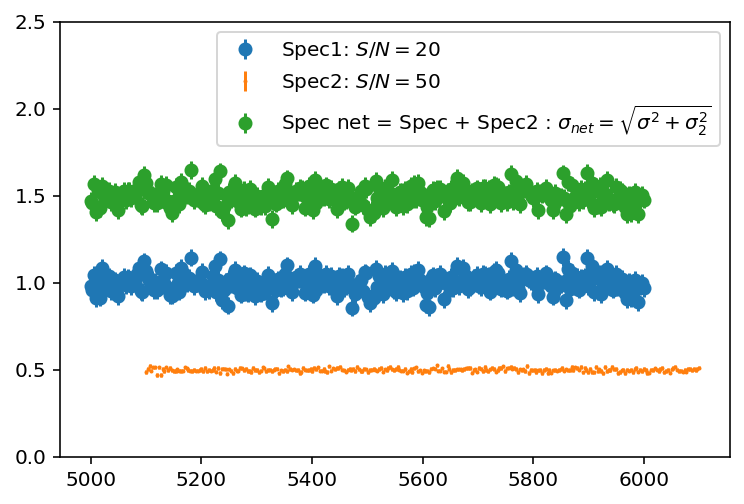

In [13]:
plt.errorbar(spec1.wavelength.value, spec1.flux.value, yerr=spec1.uncertainty.array, 
             linestyle='none', marker='o', label='Spec1: $S/N=20$')

plt.errorbar(spec2.wavelength.value, spec2.flux.value, yerr=spec2.uncertainty.array, 
             linestyle='none', marker='o', markersize=1, label='Spec2: $S/N=50$')

plt.errorbar(spec_net.wavelength.value, spec_net.flux.value, yerr=spec_net.uncertainty.array, 
             linestyle='none', marker='o', 
             label='Spec net = Spec + Spec2 : $\sigma_{net}=\sqrt{\sigma^2 + \sigma_2^2}$')
plt.legend(loc='best')
plt.ylim(0, 2.5)

Whoa! Specutils pretends like the signals are *aligned to Spectrum 1*.  That is probably not the desired behavior for such an extreme offset as this one, but may be "good enough" for spectra that are either exactly aligned or within a pixel.  It depends on your science application.  PRV applications should not just round-to-the-nearest pixel, since they are trying to infer changes at sub-pixel levels.

What if you add the two spectra *the other way around*?  Math says addition should be communitative...

In [14]:
spec_alt = spec2 + spec1

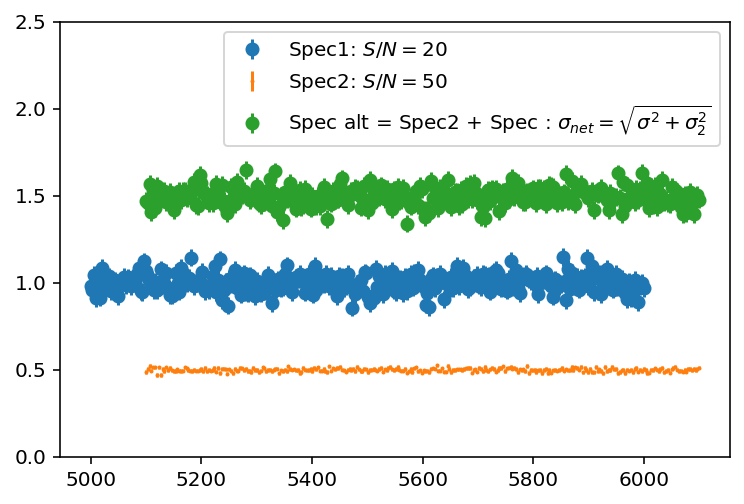

In [15]:
plt.errorbar(spec1.wavelength.value, spec1.flux.value, yerr=spec1.uncertainty.array, 
             linestyle='none', marker='o', label='Spec1: $S/N=20$')

plt.errorbar(spec2.wavelength.value, spec2.flux.value, yerr=spec2.uncertainty.array, 
             linestyle='none', marker='o', markersize=1, label='Spec2: $S/N=50$')

plt.errorbar(spec_alt.wavelength.value, spec_alt.flux.value, yerr=spec_alt.uncertainty.array, 
             linestyle='none', marker='o', label='Spec alt = Spec2 + Spec : $\sigma_{net}=\sqrt{\sigma^2 + \sigma_2^2}$')

plt.legend(loc='best')
plt.ylim(0, 2.5);

Weird, so the wavelengths of the result are taken from the bounds of the *first* argument.  This means "addition is not commutative" in specutils.  Let's see why:

In [16]:
spec_net.spectral_axis

<SpectralAxis [500.        , 500.33444816, 500.66889632, 501.00334448, 501.33779264,
   501.6722408 , 502.00668896, 502.34113712, 502.67558528, 503.01003344,
   503.34448161, 503.67892977, 504.01337793, 504.34782609, 504.68227425,
   505.01672241, 505.35117057, 505.68561873, 506.02006689, 506.35451505,
   506.68896321, 507.02341137, 507.35785953, 507.69230769, 508.02675585,
   508.36120401, 508.69565217, 509.03010033, 509.36454849, 509.69899666,
   510.03344482, 510.36789298, 510.70234114, 511.0367893 , 511.37123746,
   511.70568562, 512.04013378, 512.37458194, 512.7090301 , 513.04347826,
   513.37792642, 513.71237458, 514.04682274, 514.3812709 , 514.71571906,
   515.05016722, 515.38461538, 515.71906355, 516.05351171, 516.38795987,
   516.72240803, 517.05685619, 517.39130435, 517.72575251, 518.06020067,
   518.39464883, 518.72909699, 519.06354515, 519.39799331, 519.73244147,
   520.06688963, 520.40133779, 520.73578595, 521.07023411, 521.40468227,
   521.73913043, 522.0735786 , 522.4080

In [17]:
spec_alt.spectral_axis

<SpectralAxis [510.        , 510.33444816, 510.66889632, 511.00334448, 511.33779264,
   511.6722408 , 512.00668896, 512.34113712, 512.67558528, 513.01003344,
   513.34448161, 513.67892977, 514.01337793, 514.34782609, 514.68227425,
   515.01672241, 515.35117057, 515.68561873, 516.02006689, 516.35451505,
   516.68896321, 517.02341137, 517.35785953, 517.69230769, 518.02675585,
   518.36120401, 518.69565217, 519.03010033, 519.36454849, 519.69899666,
   520.03344482, 520.36789298, 520.70234114, 521.0367893 , 521.37123746,
   521.70568562, 522.04013378, 522.37458194, 522.7090301 , 523.04347826,
   523.37792642, 523.71237458, 524.04682274, 524.3812709 , 524.71571906,
   525.05016722, 525.38461538, 525.71906355, 526.05351171, 526.38795987,
   526.72240803, 527.05685619, 527.39130435, 527.72575251, 528.06020067,
   528.39464883, 528.72909699, 529.06354515, 529.39799331, 529.73244147,
   530.06688963, 530.40133779, 530.73578595, 531.07023411, 531.40468227,
   531.73913043, 532.0735786 , 532.4080

In [18]:
spec1.add(spec2, compare_wcs=None).spectral_axis

<SpectralAxis [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
    12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
    24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
    36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
    48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
    60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
    72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
    84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
    96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
   108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
   120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
   132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
   144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
   156., 157.

Pixels instead of nanometers!

In [19]:
spec2.add(spec1, compare_wcs='first_found').spectral_axis

<SpectralAxis [510.        , 510.33444816, 510.66889632, 511.00334448, 511.33779264,
   511.6722408 , 512.00668896, 512.34113712, 512.67558528, 513.01003344,
   513.34448161, 513.67892977, 514.01337793, 514.34782609, 514.68227425,
   515.01672241, 515.35117057, 515.68561873, 516.02006689, 516.35451505,
   516.68896321, 517.02341137, 517.35785953, 517.69230769, 518.02675585,
   518.36120401, 518.69565217, 519.03010033, 519.36454849, 519.69899666,
   520.03344482, 520.36789298, 520.70234114, 521.0367893 , 521.37123746,
   521.70568562, 522.04013378, 522.37458194, 522.7090301 , 523.04347826,
   523.37792642, 523.71237458, 524.04682274, 524.3812709 , 524.71571906,
   525.05016722, 525.38461538, 525.71906355, 526.05351171, 526.38795987,
   526.72240803, 527.05685619, 527.39130435, 527.72575251, 528.06020067,
   528.39464883, 528.72909699, 529.06354515, 529.39799331, 529.73244147,
   530.06688963, 530.40133779, 530.73578595, 531.07023411, 531.40468227,
   531.73913043, 532.0735786 , 532.4080

In [20]:
spec1.add(spec2, compare_wcs='first_found').spectral_axis

<SpectralAxis [500.        , 500.33444816, 500.66889632, 501.00334448, 501.33779264,
   501.6722408 , 502.00668896, 502.34113712, 502.67558528, 503.01003344,
   503.34448161, 503.67892977, 504.01337793, 504.34782609, 504.68227425,
   505.01672241, 505.35117057, 505.68561873, 506.02006689, 506.35451505,
   506.68896321, 507.02341137, 507.35785953, 507.69230769, 508.02675585,
   508.36120401, 508.69565217, 509.03010033, 509.36454849, 509.69899666,
   510.03344482, 510.36789298, 510.70234114, 511.0367893 , 511.37123746,
   511.70568562, 512.04013378, 512.37458194, 512.7090301 , 513.04347826,
   513.37792642, 513.71237458, 514.04682274, 514.3812709 , 514.71571906,
   515.05016722, 515.38461538, 515.71906355, 516.05351171, 516.38795987,
   516.72240803, 517.05685619, 517.39130435, 517.72575251, 518.06020067,
   518.39464883, 518.72909699, 519.06354515, 519.39799331, 519.73244147,
   520.06688963, 520.40133779, 520.73578595, 521.07023411, 521.40468227,
   521.73913043, 522.0735786 , 522.4080

A ha!  The `compare_wcs` kwarg controls what-to-do with the mis-matched spectral axes.  Basically the sum of the two spectra just takes the wavelength labels from the first spectrum and uses those, when `compare_wcs='first_found'`---the default---is provided.  It doesn't actually interpolate or anything fancy...

# Resampling

Can we resample mis-aligned spectra and still get reasonable error propagation?  How would that work?

In [21]:
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler

In [22]:
resampler = FluxConservingResampler(extrapolation_treatment='nan_fill')

In [23]:
%%capture 
#This method throws a warning for an unknown reason...
resampled_spec2 = resampler(spec2, spec1.spectral_axis)

In [24]:
resampled_spec2.uncertainty[0:50]

InverseVariance([   nan,    nan,    nan,    nan,    nan,    nan,    nan,
                    nan,    nan,    nan,    nan,    nan,    nan,    nan,
                    nan,    nan,    nan,    nan,    nan,    nan,    nan,
                    nan,    nan,    nan,    nan,    nan,    nan,    nan,
                    nan,    nan, 10000., 10000., 10000., 10000., 10000.,
                 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
                 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
                 10000.])

Hmmm... this process causes a new type of uncertainty "inverse variance" instead of std deviation... I'm not sure why!  Hmm...  We'll manually convert?  Variance is just standard-deviation squared.  Inverse is just one-over-that...

In [25]:
new_sigma = np.sqrt(1/resampled_spec2.uncertainty.array)

In [26]:
resampled_spec2.uncertainty = StdDevUncertainty(new_sigma)

In [27]:
spec_final = spec1.add(resampled_spec2, propagate_uncertainties=True)

In [28]:
spec_final.uncertainty[0:50]

StdDevUncertainty([      nan,       nan,       nan,       nan,       nan,
                         nan,       nan,       nan,       nan,       nan,
                         nan,       nan,       nan,       nan,       nan,
                         nan,       nan,       nan,       nan,       nan,
                         nan,       nan,       nan,       nan,       nan,
                         nan,       nan,       nan,       nan,       nan,
                   0.0509902, 0.0509902, 0.0509902, 0.0509902, 0.0509902,
                   0.0509902, 0.0509902, 0.0509902, 0.0509902, 0.0509902,
                   0.0509902, 0.0509902, 0.0509902, 0.0509902, 0.0509902,
                   0.0509902, 0.0509902, 0.0509902, 0.0509902, 0.0509902])

Voila!  It worked!  I am not sure why specutils does not go the whole way and do this step manually.

(0.0, 2.5)

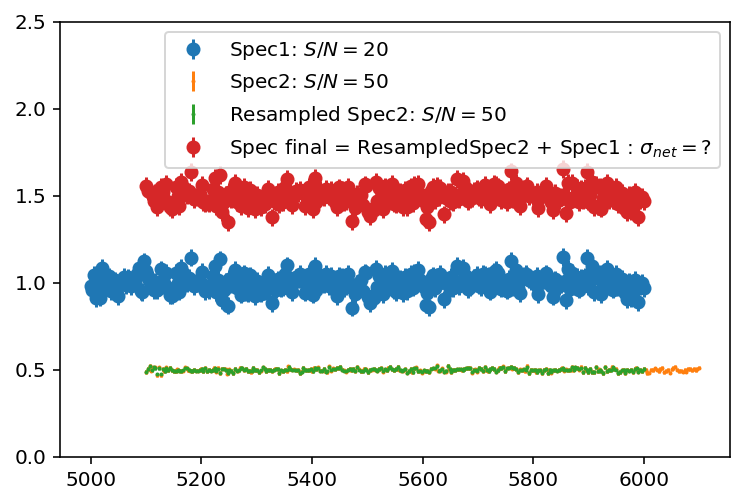

In [29]:
plt.errorbar(spec1.wavelength.value, spec1.flux.value, yerr=spec1.uncertainty.array, 
             linestyle='none', marker='o', label='Spec1: $S/N=20$')

plt.errorbar(spec2.wavelength.value, spec2.flux.value, yerr=spec2.uncertainty.array, 
             linestyle='none', marker='o', markersize=1, label='Spec2: $S/N=50$')
plt.errorbar(resampled_spec2.wavelength.value, resampled_spec2.flux.value, yerr=new_sigma, 
             linestyle='none', marker='o', markersize=1, label='Resampled Spec2: $S/N=50$')

plt.errorbar(spec_final.wavelength.value, spec_final.flux.value, yerr=spec_final.uncertainty.array, 
             linestyle='none', marker='o', label='Spec final = ResampledSpec2 + Spec1 : $\sigma_{net}=?$')

plt.legend(loc='best')
plt.ylim(0, 2.5)

Okay!  Now we understand how specutils combines spectra, both for error propagation and for comparing the spectral axes of the two spectra.  